In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from matplotlib.ticker import StrMethodFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, OPTICS, AgglomerativeClustering, KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, accuracy_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import xgboost as xgb
import colorsys
import warnings
from datetime import timedelta

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=UserWarning)

#### Import machine and ruby data

In [2]:
# import all data
removable_features= ['Produkt [None]', 'Auftragsnummer [None]', 'utc_time', 'Blasentemperatur [°C]', 'Wickler A Steigung (Soll) [%]', 'Wickler A Steigung [%]', 'Wickler B Steigung (Soll) [%]', 'Wickler B Steigung [%]']
first_dataset = pd.read_csv("../data/merged_week_21_50-22_15.csv", sep=";", on_bad_lines='skip', decimal=',', dtype = {'production_order_code [None]': 'Int64'}).dropna(subset=['production_order_code [None]']).drop(removable_features, axis='columns') 
second_dataset = pd.read_csv("../data/merged_week_22_17-22_28.csv", sep=";", on_bad_lines='skip', decimal=',', dtype = {'production_order_code [None]': 'Int64'}).dropna(subset=['production_order_code [None]']).drop(removable_features, axis='columns') 
data = pd.concat([first_dataset, second_dataset], ignore_index=True)
data['local_time'] = pd.to_datetime(data['local_time'], format="%d.%m.%Y %H:%M")

# define numeric data
numeric_columns = data.select_dtypes(include='number').drop(['product_code [None]', 'production_order_code [None]'], axis=1).loc[:, data.nunique() > 150].columns.tolist()
numeric_data_aggregated = data[['local_time'] + numeric_columns].groupby(pd.Grouper(key="local_time", freq="1min")).mean().reset_index(level=['local_time'])
int_columns = data[numeric_data_aggregated.columns.to_list()].select_dtypes(include='int').columns.tolist()
numeric_data_aggregated[int_columns] = numeric_data_aggregated[int_columns].round().astype(pd.Int64Dtype())

# import ruby data
first_warnings = pd.read_excel('../data/old_Warnings.xlsx')
second_warnings = pd.read_excel('../data/new_warnings.xlsx')#.drop(['Component', 'Summarized Warnings', 'Possible Failure', 'Mark here if relevant for Maintenance'], axis=1)
warnings_imp = pd.concat([first_warnings, second_warnings], ignore_index=True)
warnings_imp["Start"] = pd.to_datetime(warnings_imp["Start"].dt.strftime('%Y-%m-%d %H:%M:00'), format="%Y.%m.%d %H:%M:%S")
warnings_imp["End"] = pd.to_datetime(warnings_imp["Start"].dt.strftime('%Y-%m-%d %H:%M:00'), format="%Y.%m.%d %H:%M:%S")
warnings_imp = warnings_imp.sort_values(by="Start", ascending=True)
#warnings = warnings_imp.drop_duplicates(subset=['Start']) # remove total duplicates

/var/folders/wb/ds0bcygd1bz7hr_3nm8mcg_c0000gn/T/ipykernel_13151/1296706149.py:3: DtypeWarning: Columns (4,15,32,44,51,72,75,81,99,125,150,164,167,248,261) have mixed types. Specify dtype option on import or set low_memory=False.
  first_dataset = pd.read_csv("../data/merged_week_21_50-22_15.csv", sep=";", on_bad_lines='skip', decimal=',', dtype = {'production_order_code [None]': 'Int64'}).dropna(subset=['production_order_code [None]']).drop(removable_features, axis='columns')
/var/folders/wb/ds0bcygd1bz7hr_3nm8mcg_c0000gn/T/ipykernel_13151/1296706149.py:4: DtypeWarning: Columns (4,15,32,44,51,72,75,81,99,125,150,164,167,218,248,261,267,281) have mixed types. Specify dtype option on import or set low_memory=False.
  second_dataset = pd.read_csv("../data/merged_week_22_17-22_28.csv", sep=";", on_bad_lines='skip', decimal=',', dtype = {'production_order_code [None]': 'Int64'}).dropna(subset=['production_order_code [None]']).drop(removable_features, axis='columns')


#### Filter warnings

In [4]:
def filter_warnings(warnings, filter_list): 
    mask = pd.Series(False, index=warnings.index)
    for substring in filter_list:
        mask |= warnings['Warning Text'].str.contains(substring)
    
    return warnings.loc[mask]

def remove_duplicates(warnings, time_diff):
    diff = warnings['Start'].diff() # Calculate the time difference between consecutive rows
    duplicate_rows = diff < timedelta(minutes=time_diff) # Find rows where the time difference is less than 5 minutes

    return warnings[~duplicate_rows] # Remove the duplicate rows within the same <time_diff> minutes

filter = ["Excess temperature"]
warnings = filter_warnings(warnings_imp, filter) # filters warnings by Warning text with OR operator
warnings = remove_duplicates(warnings, 5) # removes entries which are closer than 5 minutes

print(len(warnings))
warnings.head(25)

45


,Start,End,Type,Code,Comp,Warning Text
79,2021-12-21 17:47:00,2021-12-21 17:47:00,Warning,60-729,Plc IPC,Excess temperature heater Die head
78,2021-12-21 18:33:00,2021-12-21 18:33:00,Warning,60-729,Plc IPC,Excess temperature heater Die head
64,2021-12-23 11:36:00,2021-12-23 11:36:00,Warning,60-721,Plc IPC,Excess temperature heater extruder B
60,2021-12-23 17:25:00,2021-12-23 17:25:00,Warning,61-1421,Plc IPC,Excess temperature heater Film cooling
233,2022-01-02 14:21:00,2022-01-02 14:21:00,Warning,60-729,Plc IPC,Excess temperature heater Die head
450,2022-01-02 20:30:00,2022-01-02 20:30:00,Warning,60-729,Plc IPC,Excess temperature heater Die head
265,2022-01-12 22:20:00,2022-01-12 22:20:00,Warning,60-721,Plc IPC,Excess temperature heater extruder B
262,2022-01-12 22:29:00,2022-01-12 22:29:00,Warning,60-721,Plc IPC,Excess temperature heater extruder B
261,2022-01-12 22:44:00,2022-01-12 22:44:00,Warning,60-721,Plc IPC,Excess temperature heater extruder B
257,2022-01-13 09:58:00,2022-01-13 09:58:00,Warning,60-720,Plc IPC,Excess temperature heater extruder A


#### Create Labels couting down the time until next alarm 

In [4]:
numeric_data_aggregated['Label'] = numeric_data_aggregated['local_time'].apply(lambda x: 1 if x in warnings['Start'].to_list() else 0) # markt overheating timestamps with 1 else 0
last_failure_index = numeric_data_aggregated.loc[numeric_data_aggregated['local_time'] == warnings['Start'].to_list()[len(warnings['Start'].to_list()) -1]].index[0] # list of failure indices
data_until_last_failure = numeric_data_aggregated[:last_failure_index +1] # cuts data after last failure

label_data = data_until_last_failure['Label'].to_list()
next_failure_index = label_data.index(1, 0) 
failure_in_this_iteration = False 

for i in range(len(label_data)):
    if failure_in_this_iteration:
        next_failure_index = label_data.index(1, i) 
        failure_in_this_iteration = False

    label_data[i] = next_failure_index  - i

    if next_failure_index - i == 0: 
        failure_in_this_iteration = True

data_until_last_failure['Label'] = label_data

/var/folders/wb/ds0bcygd1bz7hr_3nm8mcg_c0000gn/T/ipykernel_25256/717615246.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_until_last_failure['Label'] = label_data


#### Only consider specific features and remove NaN values

In [5]:
col_search_words = ['Temperatur', 'Extruder'] # Only consider columns with these words in name
standard_columns = ['local_time', 'Label']

# Select columns containing any word from the list
searched_columns = [col for col in data_until_last_failure.columns if all(word in col for word in col_search_words)]
selected_columns = standard_columns + np.sort(np.array(searched_columns)).tolist()

data_without_nan = data_until_last_failure[selected_columns].dropna(subset=searched_columns, how='all').reset_index().drop(['index'], axis=1)
data_without_nan['Label'] = np.where(data_without_nan['Label'] > 20, 10000, data_without_nan['Label']) 

#data_without_nan.to_csv('data/data_with_overheating_label.csv', index=False, sep=';', decimal = ".")

In [6]:
def remove_sample_of_normal_data(dataset, percentage):
    count_10000 = dataset[dataset['Label'] == 10000].shape[0]  # Count the number of rows with value 10000
    rows_to_keep = dataset[dataset['Label'] == 10000].sample(n=int((1- percentage / 100) * count_10000), random_state=42) # Randomly select rows to remove
    dataset = pd.concat([dataset[dataset['Label'] != 10000], rows_to_keep]) # Concatenate the rows to keep with the remaining rows
    dataset = dataset.sort_values(by="local_time", ascending=True)

    return dataset

data_without_nan = remove_sample_of_normal_data(data_without_nan, 95)    
data_without_nan

,local_time,Label,Extruder A AF1 Temperatur [°C],Extruder A Siebwechsler Temperatur [°C],Extruder A Zone 1 Temperatur [°C],Extruder A Zone 2 Temperatur [°C],Extruder A Zone 3 Temperatur [°C],Extruder A Zone 4 Temperatur [°C],Extruder B AF1 Temperatur [°C],Extruder B Siebwechsler Temperatur [°C],Extruder B Zone 1 Temperatur [°C],Extruder B Zone 2 Temperatur [°C],Extruder B Zone 3 Temperatur [°C],Extruder B Zone 4 Temperatur [°C],Extruder C AF1 Temperatur [°C],Extruder C Siebwechsler Temperatur [°C],Extruder C Zone 1 Temperatur [°C],Extruder C Zone 2 Temperatur [°C],Extruder C Zone 3 Temperatur [°C],Extruder C Zone 4 Temperatur [°C]
24,2021-12-13 00:24:00,10000,20,20,19,19,20,19,20,19,19,19,20,19,19,19,20,19,21,19
26,2021-12-13 00:26:00,10000,20,20,19,19,20,19,20,19,19,19,20,19,19,19,20,19,21,19
41,2021-12-13 00:41:00,10000,20,20,19,19,20,19,20,19,19,19,20,19,19,19,20,19,21,19
87,2021-12-13 01:27:00,10000,20,20,19,19,20,19,20,19,19,19,20,20,20,19,20,20,21,19
88,2021-12-13 01:28:00,10000,20,20,19,19,20,19,20,19,19,19,20,20,20,19,20,20,21,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281874,2022-07-08 23:53:00,4,201,200,198,190,190,195,199,180,201,179,180,180,194,180,180,180,180,180
281875,2022-07-08 23:54:00,3,201,200,198,190,190,195,199,180,201,180,179,180,194,180,180,180,180,180
281876,2022-07-08 23:55:00,2,201,200,198,190,190,195,200,180,201,180,179,180,194,180,180,180,180,180
281877,2022-07-08 23:56:00,1,201,200,198,190,190,194,200,180,201,180,179,180,195,180,179,180,180,180


In [7]:
len(data_without_nan.loc[data_without_nan['Label'] > 21])

14049

In [8]:
"""
general_data = data_without_nan.iloc[:, :2]
feature_data = data_without_nan.iloc[:, 2:] 

scaler = StandardScaler()
scaler.fit(feature_data)

standardized_data = pd.concat([general_data, pd.DataFrame(scaler.transform(feature_data), columns=feature_data.columns.to_list())], axis=1)
standardized_data
"""

'\ngeneral_data = data_without_nan.iloc[:, :2]\nfeature_data = data_without_nan.iloc[:, 2:] \n\nscaler = StandardScaler()\nscaler.fit(feature_data)\n\nstandardized_data = pd.concat([general_data, pd.DataFrame(scaler.transform(feature_data), columns=feature_data.columns.to_list())], axis=1)\nstandardized_data\n'

In [9]:
"""
pca = PCA(n_components=0.95)
pca_data = pd.DataFrame(data=pca.fit_transform(standardized_data.iloc[:, 2:]))
#explained_variance_ratio = pca.explained_variance_ratio_
#singular_values = pca.singular_values_
#pca_components = pca.components_
#loadings = pd.DataFrame(data=pca_components, columns=standardized_data.iloc[:, 2:].columns)
pca_data = pd.concat([standardized_data.iloc[:,:2], pca_data], axis=1)
pca_data
"""

'\npca = PCA(n_components=0.95)\npca_data = pd.DataFrame(data=pca.fit_transform(standardized_data.iloc[:, 2:]))\n#explained_variance_ratio = pca.explained_variance_ratio_\n#singular_values = pca.singular_values_\n#pca_components = pca.components_\n#loadings = pd.DataFrame(data=pca_components, columns=standardized_data.iloc[:, 2:].columns)\npca_data = pd.concat([standardized_data.iloc[:,:2], pca_data], axis=1)\npca_data\n'

In [10]:
second_last_warning_entry = data_without_nan.loc[data_without_nan['Label'] == 0].index.to_list()[-4] # index of second last overheating entry
last_cycle = data_without_nan.loc[data_without_nan.index > second_last_warning_entry]
all_other_cycles= data_without_nan.loc[data_without_nan.index <= second_last_warning_entry]

In [11]:
print(second_last_warning_entry)
data_without_nan.loc[:second_last_warning_entry]

261821


,local_time,Label,Extruder A AF1 Temperatur [°C],Extruder A Siebwechsler Temperatur [°C],Extruder A Zone 1 Temperatur [°C],Extruder A Zone 2 Temperatur [°C],Extruder A Zone 3 Temperatur [°C],Extruder A Zone 4 Temperatur [°C],Extruder B AF1 Temperatur [°C],Extruder B Siebwechsler Temperatur [°C],Extruder B Zone 1 Temperatur [°C],Extruder B Zone 2 Temperatur [°C],Extruder B Zone 3 Temperatur [°C],Extruder B Zone 4 Temperatur [°C],Extruder C AF1 Temperatur [°C],Extruder C Siebwechsler Temperatur [°C],Extruder C Zone 1 Temperatur [°C],Extruder C Zone 2 Temperatur [°C],Extruder C Zone 3 Temperatur [°C],Extruder C Zone 4 Temperatur [°C]
24,2021-12-13 00:24:00,10000,20,20,19,19,20,19,20,19,19,19,20,19,19,19,20,19,21,19
26,2021-12-13 00:26:00,10000,20,20,19,19,20,19,20,19,19,19,20,19,19,19,20,19,21,19
41,2021-12-13 00:41:00,10000,20,20,19,19,20,19,20,19,19,19,20,19,19,19,20,19,21,19
87,2021-12-13 01:27:00,10000,20,20,19,19,20,19,20,19,19,19,20,20,20,19,20,20,21,19
88,2021-12-13 01:28:00,10000,20,20,19,19,20,19,20,19,19,19,20,20,20,19,20,20,21,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261817,2022-06-25 01:34:00,4,220,220,222,229,219,216,221,220,234,220,220,221,220,220,225,223,219,219
261818,2022-06-25 01:35:00,3,220,220,220,228,220,218,220,220,234,220,220,220,220,220,223,224,219,219
261819,2022-06-25 01:36:00,2,220,220,219,226,221,219,220,220,234,220,220,220,220,220,220,224,219,219
261820,2022-06-25 01:37:00,1,220,220,220,223,222,221,220,220,234,220,220,220,220,220,220,224,219,219


#### Prediction

Define training, validation and test dataset

In [12]:
#training, validation & test data
train_data, val_data = train_test_split(all_other_cycles, test_size=0.2, random_state=42)
test_data = last_cycle

y_train, X_train = train_data.to_numpy()[:,1:2], train_data.to_numpy()[:,2:]
y_val, X_val = val_data.to_numpy()[:,1:2], val_data.to_numpy()[:,2:]
y_test, X_test = test_data.to_numpy()[:,1:2], test_data.to_numpy()[:,2:]

In [13]:
model = xgb.XGBRegressor(objective ='reg:squarederror', 
                             colsample_bytree = 0.6, 
                             learning_rate = 0.2,
                             max_depth = 4,
                             reg_lambda = 1,
                             n_estimators = 1000)

# fit the model
model.fit(X_train, y_train, eval_metric=["rmse"], eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-rmse:7865.94563	validation_1-rmse:7902.97787
[1]	validation_0-rmse:6431.24900	validation_1-rmse:6458.94059
[2]	validation_0-rmse:5312.10129	validation_1-rmse:5325.81437
[3]	validation_0-rmse:4449.80495	validation_1-rmse:4447.41639
[4]	validation_0-rmse:3777.29449	validation_1-rmse:3757.43950
[5]	validation_0-rmse:3276.30028	validation_1-rmse:3239.47839
[6]	validation_0-rmse:2885.21140	validation_1-rmse:2839.91001
[7]	validation_0-rmse:2604.51542	validation_1-rmse:2555.61133
[8]	validation_0-rmse:2417.54913	validation_1-rmse:2357.00145
[9]	validation_0-rmse:2277.91760	validation_1-rmse:2202.56869
[10]	validation_0-rmse:2184.95891	validation_1-rmse:2098.86293
[11]	validation_0-rmse:2113.36900	validation_1-rmse:2021.28791
[12]	validation_0-rmse:2042.73311	validation_1-rmse:1955.97864
[13]	validation_0-rmse:2008.26618	validation_1-rmse:1918.13527
[14]	validation_0-rmse:1978.78775	validation_1-rmse:1888.14326
[15]	validation_0-rmse:1951.12029	validation_1-rmse:1865.74542


[16]	validation_0-rmse:1910.29050	validation_1-rmse:1829.79112
[17]	validation_0-rmse:1890.33447	validation_1-rmse:1812.41388
[18]	validation_0-rmse:1865.65947	validation_1-rmse:1795.25236
[19]	validation_0-rmse:1827.37158	validation_1-rmse:1764.09684
[20]	validation_0-rmse:1803.69789	validation_1-rmse:1738.58239
[21]	validation_0-rmse:1791.49967	validation_1-rmse:1727.75545
[22]	validation_0-rmse:1782.13669	validation_1-rmse:1717.01543
[23]	validation_0-rmse:1774.79941	validation_1-rmse:1713.55484
[24]	validation_0-rmse:1758.76559	validation_1-rmse:1699.14624
[25]	validation_0-rmse:1752.83111	validation_1-rmse:1692.18353
[26]	validation_0-rmse:1731.02451	validation_1-rmse:1676.37975
[27]	validation_0-rmse:1714.20444	validation_1-rmse:1655.92165
[28]	validation_0-rmse:1693.35221	validation_1-rmse:1641.30755
[29]	validation_0-rmse:1674.81748	validation_1-rmse:1630.04442
[30]	validation_0-rmse:1658.68355	validation_1-rmse:1615.73193
[31]	validation_0-rmse:1645.61363	validation_1-rmse:159

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

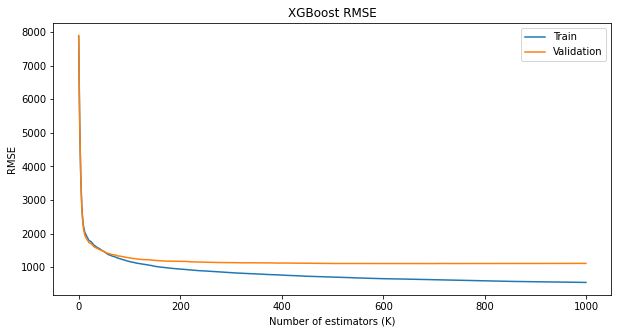

<Figure size 432x288 with 0 Axes>

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

results = model.evals_result()
epochs = len(results['validation_0']['rmse'])

x_axis = range(0, epochs)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Validation')
ax.legend()
ax.set_title('XGBoost RMSE')
ax.set_ylabel('RMSE')
ax.set_xlabel('Number of estimators (K)')
plt.show()
plt.tight_layout()

In [15]:
preds = model.predict(X_test)

RMSE: 2764.4497049431516


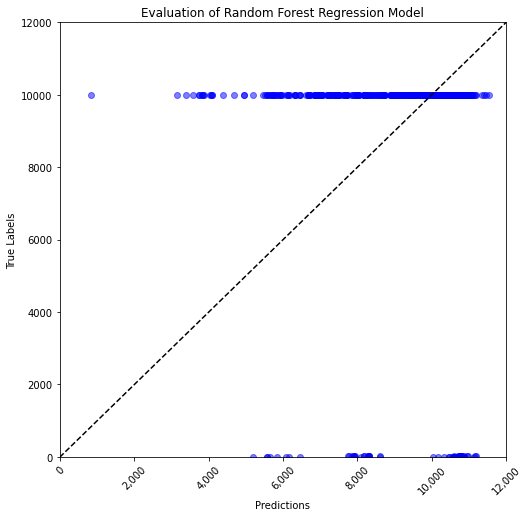

In [16]:
# compute RMSE
print("RMSE: {}".format(np.sqrt(mean_squared_error(y_test, preds))))
max_value = 12000
# visualize predictions vs. true labels
fig = plt.figure(figsize=(8,8))
plt.scatter(preds, y_test, color="blue", alpha=0.5)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.plot([-10,max_value], [-10, max_value], 'k--')
plt.xlabel("Predictions")
plt.ylabel("True Labels")
plt.xlim([-10,max_value])
plt.ylim([-10,max_value])
plt.title("Evaluation of Random Forest Regression Model")
plt.show()

In [17]:
parameters = {'objective':['reg:squarederror'],
              'learning_rate': [0.4],
              'max_depth': [6],
              'colsample_bytree': [0.6],
              'n_estimators': [800],
              'reg_lambda': [0]
             }

grid_search = GridSearchCV(
                        xgb.XGBRegressor(),
                        parameters,
                        cv = 3,
                        refit=True, 
                        verbose=True)

%time grid_search.fit(X_train, y_train, eval_metric=["rmse"], eval_set=[(X_train, y_train), (X_val, y_val)])
model = grid_search.best_estimator_

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[0]	validation_0-rmse:6033.27260	validation_1-rmse:6058.15032
[1]	validation_0-rmse:3912.36987	validation_1-rmse:3924.82357
[2]	validation_0-rmse:2787.85812	validation_1-rmse:2769.78795
[3]	validation_0-rmse:2098.42017	validation_1-rmse:2070.70520
[4]	validation_0-rmse:1772.61226	validation_1-rmse:1764.84880
[5]	validation_0-rmse:1604.81787	validation_1-rmse:1602.72384
[6]	validation_0-rmse:1514.33922	validation_1-rmse:1522.79922
[7]	validation_0-rmse:1413.78900	validation_1-rmse:1456.03081
[8]	validation_0-rmse:1367.07925	validation_1-rmse:1435.03061
[9]	validation_0-rmse:1340.68693	validation_1-rmse:1424.89046
[10]	validation_0-rmse:1290.01971	validation_1-rmse:1385.75217
[11]	validation_0-rmse:1238.39863	validation_1-rmse:1363.27668
[12]	validation_0-rmse:1195.27326	validation_1-rmse:1344.16412
[13]	validation_0-rmse:1179.92740	validation_1-rmse:1343.45313
[14]	validation_0-rmse:1172.33696	validation_1-rmse:1345.32723
[15]	validation_0-rmse:1158.69864	validation_1-rmse:1337.79061
[1

#### Evaluating data

In [18]:
#grid_search.best_params_

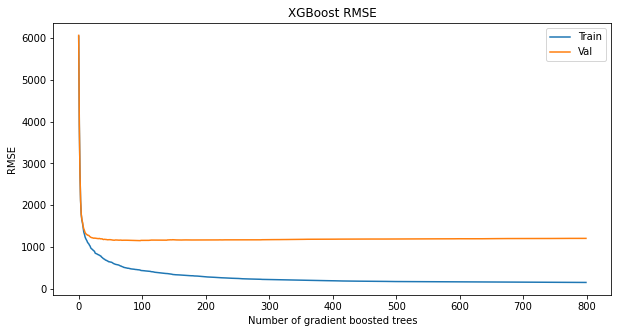

<Figure size 432x288 with 0 Axes>

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

results = model.evals_result()
epochs = len(results['validation_0']['rmse'])

x_axis = range(0, epochs);
fig, ax = plt.subplots(1, 1, figsize=(10,5));
ax.plot(x_axis, results['validation_0']['rmse'], label='Train');
ax.plot(x_axis, results['validation_1']['rmse'], label='Val');
ax.legend();
ax.set_title('XGBoost RMSE');
ax.set_ylabel('RMSE');
ax.set_xlabel('Number of gradient boosted trees');
plt.show();
plt.tight_layout();

In [20]:
prediction = model.predict(X_test)
print("RMSE test: {}".format(np.sqrt(mean_squared_error(y_test, prediction))))

RMSE test: 2943.022039061196


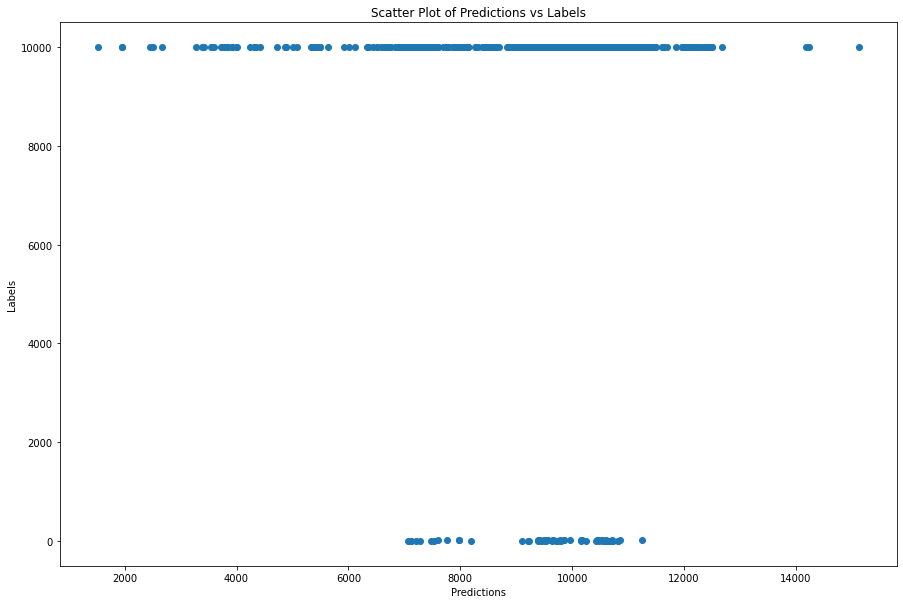

In [21]:
# Create a scatter plot
plt.figure(figsize=(15, 10))
plt.scatter(prediction, y_test)

# Add labels and title
plt.xlabel("Predictions")
plt.ylabel("Labels")
plt.title("Scatter Plot of Predictions vs Labels")

# Display the plot
plt.show()